# 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, vmap, config
import jaxquantum as jqt
import qcsys as qs
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

# 2 - Set Up Bare Qubit

In this tutorial, we will demonstrate how to analyze a driven qubit using Floquet theory. For the bare qubit, here we will use a Kerr nonlinear oscillator with a Hamiltonian of the form
$$
\hat{H}_0 = \omega \hat{a}^\dagger \hat{a} + \frac{\alpha}{2}\hat{a}^\dagger{}^2 \hat{a}^2
$$
where $\omega$ and $\alpha$ are the frequency and anharmonicity, respectively. 

In [3]:
qubit = qs.KNO.create(N=5, params={"ω": 5, "α": -0.15})
bare_ω_ge = qubit.eig_systems['vals'][1] - qubit.eig_systems['vals'][0]
qubit.eig_systems['vals']

Array([ 0.  ,  5.  ,  9.85, 14.55, 19.1 ], dtype=float64)

# 3 - Create Floquet qubit

Let's consider a "charge"-like drive on the Kerr nonlinear oscillator above. Specifically, we will consider a time-dependent Hamiltonian of the form
$$
\hat{H}(t) = \hat{H}_0 + \Omega(\hat{a} + \hat{a}^\dagger)\cos(\omega_d t),
$$
where $\Omega$ is the effective drive amplitude and $\omega_d$ is the drive frequency. This Hamiltonian is time-periodic with $\hat{H}(t) = \hat{H}(t + T)$, where $T = 2\pi/\omega_d$. Therefore, we can study this system in the Floquet basis by making use of the Floquet theorem. Specifically,  we know that the above Hamiltonian admits a set of quasi-energies and Floquet modes that are solutions of the Schrodinger equation:
$$
|\psi_\alpha(t)\rangle = e^{-i\epsilon_\alpha t/\hbar}\,\, |u_\alpha(t)\rangle,
$$
where $\epsilon_\alpha$ are called the quasi-energies (unique mod. $\hbar \omega_d)$ and $|u_\alpha\rangle$ are called the Floquet modes, which are time-periodic: $|u_\alpha(t)\rangle = |u_\alpha(t + T)\rangle$. We can rewrite the Schrodinger equation:
$$
\Big[\hat{H}(t) - i\partial_t\Big] |u_\alpha(t)\rangle = \epsilon_\alpha |u_\alpha(t)\rangle
$$

and the Hamiltonian on the right hand side is known as the Floquet Hamiltonian $\hat{H}_F \equiv H(t) - i\partial / \partial t$. 


-----------------


In this tutorial, we use a generalized version of the Sambe/Shirley extended Hilbert space formalism to treat the Floquet Hamiltonian. Specifically, we can write the phase of the drive as $\theta(t) = \omega_d t$ here. We then can write the Floquet Hamiltonian above as:
$$
\hat{H}_F = \hat{H}_0 + \Omega(\hat{a} + \hat{a}^\dagger)\cos(\theta(t)) -i\omega_d \partial_\theta
$$

In the extended Hilbert space approach to Floquet theory, our next step is to rewrite $\hat{H}_F$ in terms of its Fourier components, and then reorganize the resulting Hamiltonian into an infinite-dimensional matrix. We then truncate to a finite number of Fourier components to get the Floquet Hamiltonian in the expanded space. However, a shortcut to doing this is to realize that this transformation is equivalent to simply promoting $\theta(t)$ to a $2\pi$-periodic quantum degree of freedom $\theta(t) \to \hat{\vartheta}$. The extended Hilbert space is then the tensor product of the bare qubit Hilbert space and the fictitious one associated with this new degree of freedom. Thus: 
$$
\hat{H}_F = \hat{H}_0 + \Omega(\hat{a} + \hat{a}^\dagger)\cos(\hat{\vartheta}) + \omega_d \hat{m},
$$
where we also introduce $\hat{m}$ as the conjugate variable to $\hat{\vartheta}$, satisfying $[\hat{\vartheta}, \hat{m}] = i$. Numerically, $\hat{\vartheta}$ and $\hat{m}$ are constructed just like the phase and charge operators for a transmon qubit, i.e. $\hat{m} = \sum_m m |m\rangle\langle m|$ and $\cos(\hat{\vartheta}) = \sum_m |m+1\rangle\langle m| + {\rm h.c.}$


Within the framework of `qcsys`, we can now interpret the Floquet Hamiltonian $\hat{H}_F$ as a coupled quantum system. The bare qubit has a Hamiltonian $\hat{H}_0$, and the "bare drive" is an infinite ladder $\omega_d \hat{m}$. The operator coupling the qubit and the drive is the drive Hamiltonian $\Omega(\hat{a} + \hat{a}^\dagger)\otimes\cos(\hat{\vartheta})$

In [4]:
def create_H_F(Ω, ωd):
    # The drive has 2*M_max + 1 levels
    drive = qs.Drive.create(M_max=5, ωd=ωd)

    # Define system
    coupling = jqt.tensor(Ω * (qubit.ops["a"] + qubit.ops["a_dag"]), drive.ops["cos(θ)"])
    system = qs.System.create([qubit, drive], [coupling])

    return system

In [5]:
# Create Floquet qubit
fq = create_H_F(0, 8)
fq.get_H()

Quantum array: dims = [[5, 11], [5, 11]], shape = (55, 55), type = oper
Qarray data =
[[-40. +0.j   0. +0.j   0. +0.j ...   0. +0.j   0. +0.j   0. +0.j]
 [  0. +0.j -32. +0.j   0. +0.j ...   0. +0.j   0. +0.j   0. +0.j]
 [  0. +0.j   0. +0.j -24. +0.j ...   0. +0.j   0. +0.j   0. +0.j]
 ...
 [  0. +0.j   0. +0.j   0. +0.j ...  43.1+0.j   0. +0.j   0. +0.j]
 [  0. +0.j   0. +0.j   0. +0.j ...   0. +0.j  51.1+0.j   0. +0.j]
 [  0. +0.j   0. +0.j   0. +0.j ...   0. +0.j   0. +0.j  59.1+0.j]]

# 4 - AC Stark Shift

Since $\hat{H}_F$ is comprised of two coupled systems, it must have two quantum numbers. We labels these as $\alpha$ for the qubit and $m$ for the drive. Therefore, diagonalizing $\hat{H}_F$, we will get a list of energy eigenvalues $E_{\alpha, m}$ and eigenvectors $|v_{\alpha, m}\rangle$. However, a Floquet system is different from a regular coupled system in that the various drive levels $m$ are redundant, i.e. they are identical Floquet replicates, i.e., we have :
$$E_{\alpha, m} = E_{\alpha, 0} + m\omega_d$$ 

We can thus pick any drive index $m$ to look at the driven eigenstates, since only $N$ of the $N \times (2 M_{\rm max} + 1)$ levels correspond to unique states in the lab frame. The conventional choice is $m = 0$, since here the Floquet dressed energies $E_{\alpha, 0}$ match up with the bare spectrum of the qubit. Another choice is to take all energies modulo $\omega_d$, in which case the energies match up with the Floquet quasi-energies $\epsilon_\alpha$ above. 

In [6]:
def get_qubit_energies(Ω, ωd):
    """ 
    Note: the index m of the drive runs from -M_max to M_max. Therefore, the m = 0 state is at numerical index M_max.
    """
    
    fq = create_H_F(Ω, ωd)
    eval, _ = fq.calculate_eig()

    return eval[:, fq.devices[1].M_max]

In [7]:
get_qubit_energies_vs_Ω = jit(vmap(get_qubit_energies, in_axes=(0, None)))

In [8]:
drive_amps = jnp.linspace(0, 0.2, 101) # Up to 200 MHz Rabi rate
drive_freq = bare_ω_ge + 0.1 # 100 MHz detuned from the qubit
energies = get_qubit_energies_vs_Ω(drive_amps, 5.1)

Text(0, 0.5, 'Qubit frequency $f_{\\rm ge}$ (MHz)')

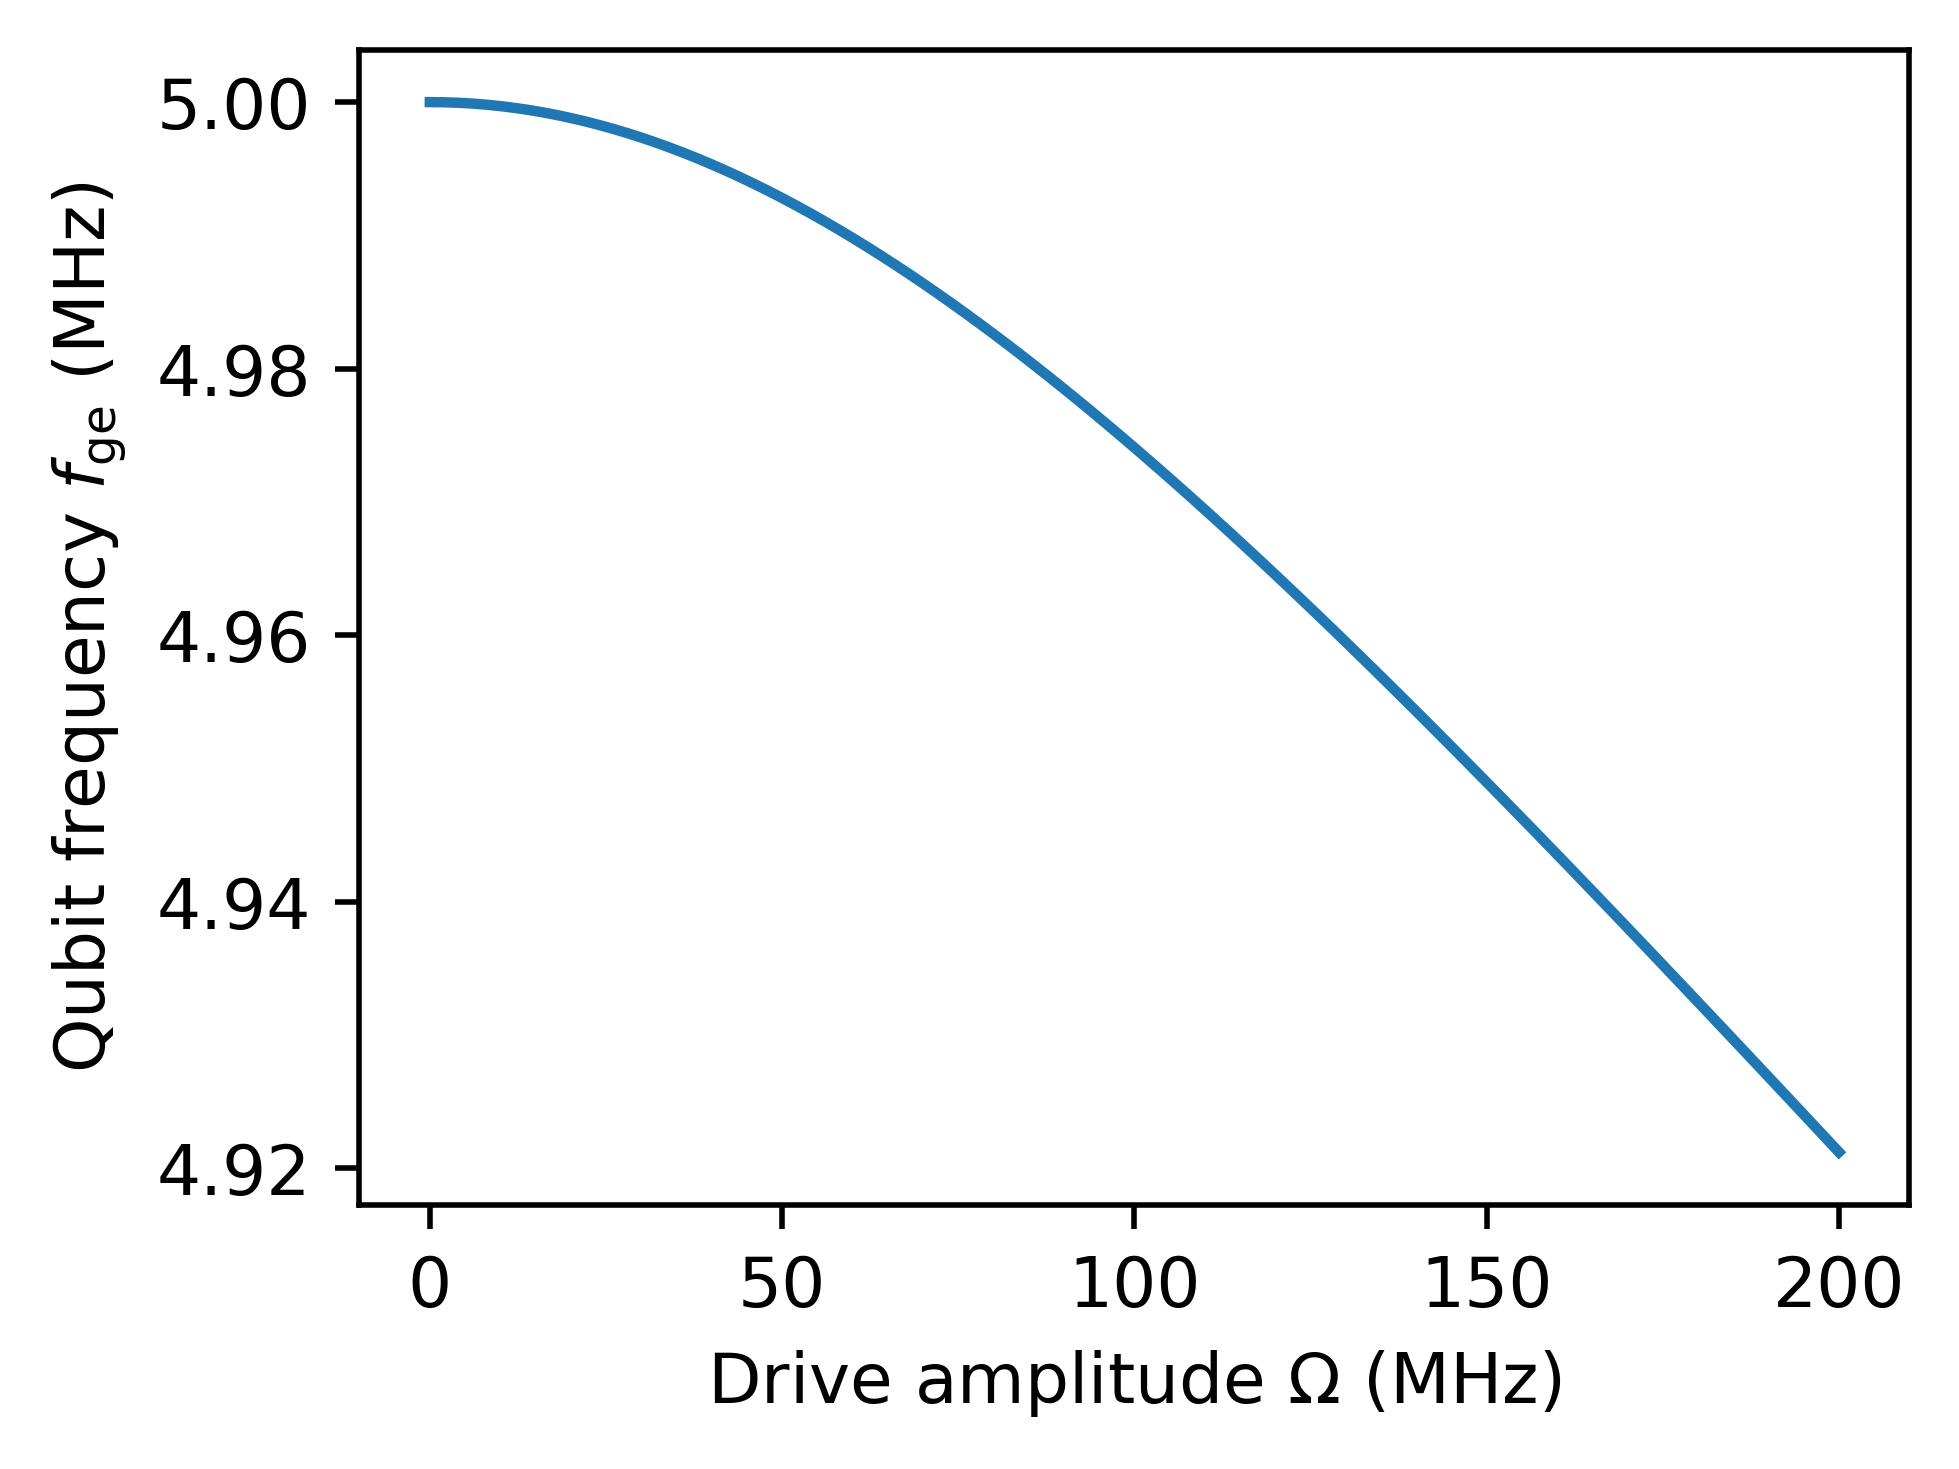

In [9]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=500)

ax.plot(drive_amps * 1e3, energies[:, 1] - energies[:, 0])
ax.set_xlabel(r"Drive amplitude $\Omega$ (MHz)")
ax.set_ylabel(r"Qubit frequency $f_{\rm ge}$ (MHz)")